In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame

import utils
import requests

In [2]:
from typing import List, Deque
from dataclasses import dataclass
@dataclass
class Vout:
    def __init__(self, scriptpubkey: str, scriptpubkey_asm: str, scriptpubkey_type: str, value: int, scriptpubkey_address: str | None = None):
        self.scriptpubkey = scriptpubkey
        self.scriptpubkey_asm = scriptpubkey_asm
        self.scriptpubkey_type = scriptpubkey_type
        self.scriptpubkey_address = scriptpubkey_address
        self.value = value

    scriptpubkey: str
    scriptpubkey_asm: str
    scriptpubkey_type: str
    scriptpubkey_address: str | None
    value: int

@dataclass
class Vin:
    def __init__(self, txid: str, scriptsig_asm: str, vout: int, prevout: Vout | None, scriptsig: str, witness: List[str], is_coinbase: bool, sequence: int, inner_witnessscript_asm: str | None = None):
        self.txid = txid
        self.vout = vout
        self.prevout = prevout
        self.scriptsig = scriptsig
        self.scriptsig_asm = scriptsig_asm
        self.witness = witness
        self.is_coinbase = is_coinbase
        self.sequence = sequence
        self.inner_witnessscript_asm = inner_witnessscript_asm

    txid: str
    vout: int
    prevout: Vout | None
    scriptsig: str
    scriptsig_asm: str
    witness: List[str]
    is_coinbase: bool
    sequence: int
    inner_witnessscript_asm: str | None

@dataclass
class Status:
    confirmed: bool
    block_height: int
    block_hash: str
    block_time: int

@dataclass
class Transaction:
  txid: str
  version: int
  locktime: int
  vin: List[Vin]
  vout: List[Vout]
  size: int
  weight: int
  sigops: int
  fee: int
  status: Status

@dataclass
class TransactionWithChange(Transaction):
    change_address: str
    change_vout_index: int

# import data from JSON
import json
from json import JSONDecodeError
def build_vin(vin) -> Vin:
    # print(f"\nPrevout: {vin["prevout"]}")
    prevout = None
    if vin["prevout"] is not None:
        prevout = Vout(**vin["prevout"])
    return Vin(
        txid=vin["txid"],
        vout=vin["vout"],
        # prevout=Vout(**vin["prevout"]) if "prevout" in vin else None,
        prevout=prevout,
        scriptsig=vin["scriptsig"],
        scriptsig_asm=vin["scriptsig_asm"],
        witness=[wit for wit in vin["witness"]] if "witness" in vin else [],
        is_coinbase=vin["is_coinbase"],
        sequence=vin["sequence"],
    )

def build_tx(tx)->Transaction:
    # print(f"\n{tx['vin']}")
    return Transaction(
        txid=tx["txid"],
        version=tx["version"],
        locktime=tx["locktime"],
        vin=[build_vin(vi) for vi in tx["vin"]],
        vout=[Vout(**vout) for vout in tx["vout"]],
        size=tx["size"],
        weight=tx["weight"],
        sigops=tx["sigops"],
        fee=tx["fee"],
        status=Status(**tx["status"])
    )

def build_tx_with_change(tx) -> TransactionWithChange:
    return TransactionWithChange(**vars(build_tx(tx)), change_address=tx["change_address"], change_vout_index=tx["change_vout_index"])

def load_transactions(filename: str) -> List[TransactionWithChange]:
    try:
        with open(filename, "r", encoding="utf-8") as f:
            data = json.load(f)
            txs: List[TransactionWithChange] = []
            i = 0
            for tx in data:
                txs.append(build_tx_with_change(tx))
                i += 1
            return txs
    except FileNotFoundError:
        print("Datei nicht gefunden.")
    except JSONDecodeError as e:
        print("Ungültiges JSON:", e)


In [3]:
# transactions = load_transactions("transactions_with_change.json")
transactions = load_transactions("rbf_new_transactions.json")

In [4]:
len(transactions)

4991

In [5]:
transactions[3]

TransactionWithChange(txid='5e917829cb076425a28c40075b14cfb27717675ad6598e367bb19e4e185a7b2d', version=2, locktime=0, vin=[Vin(txid='61393cb157e334ff154289420d172ea55a99ef7ad8c620dd96cd8d4c43706712', vout=1, prevout=Vout(scriptpubkey='00149778aa4e46989b33d6024314163c5ef605292e74', scriptpubkey_asm='OP_0 OP_PUSHBYTES_20 9778aa4e46989b33d6024314163c5ef605292e74', scriptpubkey_type='v0_p2wpkh', scriptpubkey_address='bc1qjau25njxnzdn84szgv2pv0z77czjjtn5p0h04r', value=39724889), scriptsig='', scriptsig_asm='', witness=['304402205b07643bb0a6e8d59f89713654d994b66b56f3ea6b5b1df1f794d140138b80ac022017705c9fcf4791cf23f6fc3a968e2ca00195ea3fd3f6ab2c05adbdee5f311d1b01', '03a4e94573dd82f1fce691711779b44276c8ef74b2418a96173559a583fa508c6c'], is_coinbase=False, sequence=4294967293, inner_witnessscript_asm=None)], vout=[Vout(scriptpubkey='76a91413c2dd7040a25049ba3bc3272b2d624782ae0bf688ac', scriptpubkey_asm='OP_DUP OP_HASH160 OP_PUSHBYTES_20 13c2dd7040a25049ba3bc3272b2d624782ae0bf6 OP_EQUALVERIFY OP_CH

In [6]:
def filter_unique_addresses(outputs: List[Vout]) -> bool:
    adrs = [a.scriptpubkey_address for a in outputs]
    return len(adrs) == len(set(adrs))

In [7]:
filtered_transactions = [transaction for transaction in transactions if filter_unique_addresses(transaction.vout)]

In [8]:
print(f"{len(filtered_transactions)} filtered Transactions and {len(transactions)} unfiltered transactions.")

4803 filtered Transactions and 4991 unfiltered transactions.


In [9]:
len(list(filter(lambda x: x.txid == 'bae00adfc110269ad76abdd1312f84e86e7d16aa1eab0a21f4fe9ff6c54cb5fe', filtered_transactions)))

0

In [10]:
def fetch_tx(txid: str, tx_cache: Dict[str, Transaction], timeout: int = 10) -> Transaction:
    if txid in tx_cache:
        # print(f"Fetching cached {txid}")
        return tx_cache[txid]

    # print(f"Fetching {txid}")
    r = requests.get(f"http://141.55.225.221:3000/tx/{txid}", timeout=timeout)
    r.raise_for_status()
    data = r.json()
    tx = build_tx(data)
    tx_cache[txid] = tx

    return tx

In [11]:
for idx, tx in enumerate(transactions):
    print(f"{idx} - {len(tx.vin)}")

0 - 1
1 - 1
2 - 1
3 - 1
4 - 1
5 - 1
6 - 1
7 - 1
8 - 1
9 - 1
10 - 1
11 - 1
12 - 1
13 - 1
14 - 1
15 - 1
16 - 1
17 - 9
18 - 1
19 - 1
20 - 1
21 - 1
22 - 1
23 - 1
24 - 1
25 - 1
26 - 2
27 - 1
28 - 1
29 - 1
30 - 1
31 - 1
32 - 1
33 - 2
34 - 1
35 - 1
36 - 1
37 - 1
38 - 1
39 - 1
40 - 1
41 - 1
42 - 2
43 - 2
44 - 1
45 - 1
46 - 1
47 - 1
48 - 1
49 - 1
50 - 1
51 - 1
52 - 1
53 - 1
54 - 1
55 - 1
56 - 1
57 - 1
58 - 2
59 - 1
60 - 1
61 - 1
62 - 1
63 - 1
64 - 1
65 - 1
66 - 1
67 - 1
68 - 1
69 - 1
70 - 3
71 - 1
72 - 1
73 - 1
74 - 1
75 - 1
76 - 1
77 - 1
78 - 1
79 - 1
80 - 1
81 - 1
82 - 1
83 - 2
84 - 1
85 - 1
86 - 1
87 - 1
88 - 1
89 - 2
90 - 2
91 - 1
92 - 1
93 - 1
94 - 1
95 - 1
96 - 1
97 - 1
98 - 1
99 - 1
100 - 8
101 - 3
102 - 1
103 - 1
104 - 1
105 - 1
106 - 1
107 - 3
108 - 41
109 - 1
110 - 1
111 - 1
112 - 1
113 - 1
114 - 1
115 - 1
116 - 1
117 - 1
118 - 1
119 - 1
120 - 1
121 - 1
122 - 1
123 - 1
124 - 1
125 - 1
126 - 1
127 - 1
128 - 1
129 - 1
130 - 1
131 - 4
132 - 1
133 - 1
134 - 1
135 - 1
136 - 1
137 - 1
138 -

In [12]:
cache = {}
for input in transactions[22].vin:
    if not input.is_coinbase:
        print(fetch_tx(input.txid, cache, 10))

Transaction(txid='d57fd3071636d0a02fbbe7987487660afe2a7a15adf333e77e456310bff93ab4', version=2, locktime=0, vin=[Vin(txid='697a8c54f1354d18d880e405c7896b61e3cafdbc22792a5c7207c1c434040a22', vout=0, prevout=Vout(scriptpubkey='00149ffa2d0d7af46a14b551cdcda3cc98142814c9a1', scriptpubkey_asm='OP_0 OP_PUSHBYTES_20 9ffa2d0d7af46a14b551cdcda3cc98142814c9a1', scriptpubkey_type='v0_p2wpkh', scriptpubkey_address='bc1qnlaz6rt6734pfd23ehx68nyczs5pfjdp6ct0aa', value=1589726), scriptsig='', scriptsig_asm='', witness=['3044022055f6cf39dbeef8513f12835b6150472898240edf359fe05d3c0ce2719fc077e202206ad1f86bbd3f95cbc03a790e126a8ac2ab8c5895add6bcf05176a3bbe8a229d301', '0373c907a37694d7240afa49487c52b2d1295a6489a6d5e67f61ce41aa5e81fa29'], is_coinbase=False, sequence=4294967293, inner_witnessscript_asm=None)], vout=[Vout(scriptpubkey='00149ffa2d0d7af46a14b551cdcda3cc98142814c9a1', scriptpubkey_asm='OP_0 OP_PUSHBYTES_20 9ffa2d0d7af46a14b551cdcda3cc98142814c9a1', scriptpubkey_type='v0_p2wpkh', scriptpubkey_addr

In [13]:
from collections import deque
from dataclasses import asdict
import math
from typing import Dict, Any, Callable, Deque, List, Optional, Set, Tuple, Union

# ---- Deine Dataclasses (wie bereitgestellt) werden vorausgesetzt ----
# Vout, Vin, Status, Transaction, TransactionWithChange

Number = Union[int, float]
FeatureDict = Dict[str, Number]

# ---------------------------- ID-Helfer --------------------------------------

def tx_node_id(txid: str) -> str:
    return f"tx:{txid}"

def out_node_id(prev_txid: str, vout_idx: int) -> str:
    return f"out:{prev_txid}:{vout_idx}"

def canon_id(nid: str) -> str:
    # Falls du utils.canon_id hast, ersetze diese Funktion.
    return nid

# ----------------------- Feature-Extraktoren ---------------------------------

def _safe_mean(vals: List[Number]) -> float:
    return float(sum(vals) / len(vals)) if vals else 0.0

def _safe_variance(vals: List[Number]) -> float:
    if not vals:
        return 0.0
    m = _safe_mean(vals)
    return float(sum((v - m) ** 2 for v in vals) / len(vals))

def _safe_std(vals: List[Number]) -> float:
    return _safe_variance(vals) ** 0.5

def _safe_quantile(vals: List[Number], q: float) -> float:
    # einfache, deterministische Quantilsberechnung ohne numpy
    if not vals:
        return 0.0
    xs = sorted(vals)
    if len(xs) == 1:
        return float(xs[0])
    # Position gemäß linearer Interpolation
    pos = (len(xs) - 1) * q
    lo = int(pos)
    hi = min(lo + 1, len(xs) - 1)
    frac = pos - lo
    return float(xs[lo] * (1 - frac) + xs[hi] * frac)

def extract_tx_features(tx: Transaction) -> FeatureDict:
    vins: List[Vin] = tx.vin or []
    vouts: List[Vout] = tx.vout or []

    # 0. Locktime
    locktime: int = tx.locktime
    is_timestamp_lock: int = int(locktime >= 500_000_000)

    confirmed_block: int = tx.status.block_height if tx.status else 0
    confirmed_time: int = tx.status.block_time if tx.status else 0

    blocks_until_unlock: int = (locktime - confirmed_block) if not is_timestamp_lock else 0
    seconds_until_unlock: int = (locktime - confirmed_time) if is_timestamp_lock else 0
    if is_timestamp_lock:
        already_unlocked: int = int(confirmed_time >= locktime)
    else:
        already_unlocked = int(confirmed_block >= locktime)

    # 1. Inputs
    vals_in: List[int] = [vi.prevout.value for vi in vins if vi.prevout is not None]
    n_inputs: int = len(vals_in)
    sum_inputs: int = int(sum(vals_in))
    mean_inputs: float = _safe_mean(vals_in)
    var_inputs: float = _safe_variance(vals_in)

    # 2. Sequence & RBF
    seq_values: List[int] = [vi.sequence for vi in vins]
    min_sequence: int = min(seq_values) if seq_values else 0
    rbf_flag: int = int(any(s < 0xFFFFFFFF - 1 for s in seq_values))

    # 3. Outputs
    vals_out: List[int] = [vo.value for vo in vouts]
    n_outputs: int = len(vals_out)
    sum_outputs: int = int(sum(vals_out))
    sorted_out: List[int] = sorted(vals_out, reverse=True)
    max_output: int = sorted_out[0] if sorted_out else 0
    second_max_output: int = sorted_out[1] if len(sorted_out) > 1 else 0
    std_outputs: float = _safe_std(vals_out)
    q25_outputs: float = _safe_quantile(vals_out, 0.25)
    q75_outputs: float = _safe_quantile(vals_out, 0.75)
    dust_output_count: int = sum(1 for v in vals_out if v < 1000)

    # 4. Gebühren & Größe
    fee: int = tx.fee
    size: int = max(tx.size, 1)
    weight: int = max(tx.weight, 1)
    fee_rate_size: float = float(fee) / float(size)
    fee_rate_weight: float = float(fee) / float(weight)

    # 5. Skript/Adressentyp
    p2wpkh_count: int = sum(1 for vo in vouts if vo.scriptpubkey_type == "v0_p2wpkh")
    pct_outputs_p2wpkh: float = (p2wpkh_count / n_outputs) if n_outputs else 0.0

    # 6. SigOps & abgeleitet
    sigops: int = tx.sigops
    sigops_per_input: float = (sigops / n_inputs) if n_inputs else 0.0
    sigops_per_output: float = (sigops / n_outputs) if n_outputs else 0.0
    sigops_density: float = (sigops / weight) if weight else 0.0
    relative_sig_complexity: float = (sigops_per_input / pct_outputs_p2wpkh) if pct_outputs_p2wpkh else 0.0

    return {
        # Locktime
        "locktime": locktime,
        "is_timestamp_lock": is_timestamp_lock,
        "blocks_until_unlock": blocks_until_unlock,
        "seconds_until_unlock": seconds_until_unlock,
        "already_unlocked": already_unlocked,
        # Inputs
        "n_inputs": math.log1p(n_inputs),
        "sum_inputs": sum_inputs,
        "mean_inputs": mean_inputs,
        "var_inputs": var_inputs,
        # Sequence & RBF
        "min_sequence": min_sequence,
        "rbf_flag": rbf_flag,
        # Outputs
        "n_outputs": math.log1p(n_outputs),
        "sum_outputs": sum_outputs,
        "max_output": max_output,
        "second_max_output": second_max_output,
        "std_outputs": std_outputs,
        "q25_outputs": q25_outputs,
        "q75_outputs": q75_outputs,
        "dust_output_count": dust_output_count,
        # Fees & Raten
        "fee": fee,
        "fee_rate_size": fee_rate_size,
        "fee_rate_weight": fee_rate_weight,
        # Skript/Addr
        "pct_outputs_p2wpkh": pct_outputs_p2wpkh,
        # SigOps
        "sigops": sigops,
        "sigops_per_input": sigops_per_input,
        "sigops_per_output": sigops_per_output,
        "sigops_density": sigops_density,
        "relative_sig_complexity": relative_sig_complexity,
    }

def extract_outpoint_features(prev_tx: Transaction, vo: Vout, vout_idx: int) -> FeatureDict:
    st: str = vo.scriptpubkey_type or ""
    scr: str = vo.scriptpubkey or ""
    val: int = vo.value
    total_tx_output = sum(map(lambda x: x.value, prev_tx.vout))
    relative_value = val / total_tx_output

    return {
        "value": int(val),
        "relative_value": relative_value,
        "vout_idx": math.log1p(vout_idx),
        "is_dust": int(val < 1000),
        "script_type_p2wpkh": int(st == "v0_p2wpkh"),
        "script_type_p2tr": int(st in ("v1_p2tr", "p2tr")),
        "script_type_legacy": int(st in ("p2pkh", "p2sh", "p2pk")),
        "script_len": math.log1p(len(scr) // 2) if isinstance(scr, str) else 0,
    }

# ----------------------------- Graphbau --------------------------------------

def create_graph(
    n: int,
    root_tx: TransactionWithChange,
    fetch_tx: Callable[[str, Dict[str, Transaction], Optional[int]], Optional[Transaction]],
) -> Dict[str, Any]:
    """
    Erzeugt einen gerichteten bipartiten n-Hop-Vorgängergraphen:
      TX  -> Out  (eigene Outputs; Erzeugung)
      Out -> TX   (Konsum über Inputs)

    Nodes:
      - TX-Knoten: id=tx:{txid}, features=extract_tx_features(tx), label=None
      - Out-Knoten: id=out:{prev_txid}:{vout}, features=extract_outpoint_features(vout),
                    label: nur bei Root-TX-Outputs (1=Change, 0=Nicht-Change), sonst None

    Returns:
      {"nodes": [{"id", "features", "label"}, ...],
       "edges": [{"source", "target"}, ...]}
    """

    node_features: Dict[str, FeatureDict] = {}
    node_labels: Dict[str, Optional[int]] = {}
    edge_sources: List[str] = []
    edge_targets: List[str] = []

    queued_txs: Set[str] = set()
    visited_txs: Set[str] = set()
    outputs_emitted_for_tx: Set[str] = set()

    q: Deque[Tuple[Transaction, int]] = deque()
    q.append((root_tx, 0))
    queued_txs.add(root_tx.txid)
    tx_cache: Dict[str, Transaction] = {}

    def ensure_tx_node(tx: Transaction) -> str:
        nid = tx_node_id(tx.txid)
        if nid not in node_features:
            node_features[nid] = extract_tx_features(tx)
            node_labels[nid] = None
        return nid

    def ensure_out_node(prev_txid: str, vout_idx: int, vo: Vout, label: Optional[int]) -> Tuple[str, Optional[Transaction]]:
        nid = out_node_id(prev_txid, vout_idx)
        prev_tx = tx_cache.get(nid)
        if nid not in node_features:
            prev_tx = fetch_tx(prev_txid, tx_cache, 10)
            node_features[nid] = extract_outpoint_features(prev_tx, vo, vout_idx)
            node_labels[nid] = label
        else:
            # Root-Label überschreibt None, aber nie 0/1 mit anderem Wert
            if node_labels.get(nid) is None and label is not None:
                node_labels[nid] = label
        return nid, prev_tx

    def add_edge(src: str, tgt: str) -> None:
        edge_sources.append(src)
        edge_targets.append(tgt)

    while q:
        tx, level = q.popleft()

        # TX-Knoten
        tx_nid = ensure_tx_node(tx)

        # TX -> eigene Outputs (einmalig)
        if tx.txid not in outputs_emitted_for_tx:
            for idx, vo in enumerate(tx.vout or []):
                # Label nur für Root-Outputs:
                if level == 0:
                    # is_change = int(vo.scriptpubkey_address == root_tx.change_address) if root_tx.change_address else 0
                    is_change = idx == root_tx.change_vout_index
                    label: Optional[int] = 1 if is_change == 1 else 0
                else:
                    label = None

                out_nid, prev_tx = ensure_out_node(tx.txid, idx, vo, label)
                add_edge(tx_nid, out_nid)
            outputs_emitted_for_tx.add(tx.txid)

        if tx.txid not in visited_txs:
            visited_txs.add(tx.txid)

        # Inputs: Out -> TX, und Vorgänger enqueuen
        for vin in tx.vin or []:
            prev_txid: str = vin.txid
            vout_idx: int = vin.vout
            prevout: Vout = vin.prevout

            if prev_txid == "0000000000000000000000000000000000000000000000000000000000000000":
                continue
            out_nid, prev_tx = ensure_out_node(prev_txid, vout_idx, prevout, label=None)
            add_edge(out_nid, tx_nid)

            if level < n and prev_txid not in visited_txs and prev_txid not in queued_txs:
                if prev_tx is not None:
                    q.append((prev_tx, level + 1))
                    queued_txs.add(prev_txid)

    graph: Dict[str, Any] = {
        "nodes": [
            {"id": canon_id(nid), "features": feats, "label": node_labels.get(nid)}
            for nid, feats in node_features.items()
        ],
        "edges": [
            {"source": canon_id(src), "target": canon_id(tgt)}
            for src, tgt in zip(edge_sources, edge_targets)
        ],
    }
    return graph


In [14]:
filtered_transactions[0]

TransactionWithChange(txid='ea3fa5e9e2748175a9ce59aa6745e705976d73f79af3850c62f524fceb153cc0', version=2, locktime=0, vin=[Vin(txid='eab3aa3e06bbb3824d8da6934f639629d7b10d9080f0353aab58e6a5de1c4f54', vout=1, prevout=Vout(scriptpubkey='00146af3885c32b8be5fcc2c881b4440431479276b11', scriptpubkey_asm='OP_0 OP_PUSHBYTES_20 6af3885c32b8be5fcc2c881b4440431479276b11', scriptpubkey_type='v0_p2wpkh', scriptpubkey_address='bc1qdtecshpjhzl9lnpv3qd5gszrz3ujw6c3x6dpjn', value=156952), scriptsig='', scriptsig_asm='', witness=['3045022100a86b28c92659cfb38a1593a4fe3f9db63dd8f10ee193fcfc9b4f000932dc88ba02203486ffb1942bcc39a8116a781c44c678cecdb08e6c2ce4a018c96d811867c8b601', '02518573f81e5a708fa24318ec1fe81395d52af2b462c954d1abb9b8cb595061e4'], is_coinbase=False, sequence=1, inner_witnessscript_asm=None)], vout=[Vout(scriptpubkey='00146af3885c32b8be5fcc2c881b4440431479276b11', scriptpubkey_asm='OP_0 OP_PUSHBYTES_20 6af3885c32b8be5fcc2c881b4440431479276b11', scriptpubkey_type='v0_p2wpkh', scriptpubkey_ad

In [15]:
from pathlib import Path
FILE_PATH = Path("rbf_graph_export.ndjson")
def append_graphs(graphs):
    # 'a' = append
    with FILE_PATH.open("a", encoding="utf-8") as f:
        for g in graphs:
            line = json.dumps(g, ensure_ascii=False)
            f.write(line + "\n")


In [16]:
graphs = []

In [ ]:
for idx, tx in enumerate(filtered_transactions):
    # if idx < 9900:
    #     continue
    print(f"Transaction {idx} with ID: {tx.txid}\n")
    graphs.append(create_graph(2, tx, fetch_tx))
    if (idx + 1 )% 10 == 0:
        print(f"## {idx + 1} Transactions saved. ##")
        # append_graphs(graphs)

# print(graphs)
#
# with open("graph_export.json", 'w') as f:
#     json.dump({
#         "graphs": graphs,
#     }, f, indent=2)


Transaction 0 with ID: ea3fa5e9e2748175a9ce59aa6745e705976d73f79af3850c62f524fceb153cc0

Transaction 1 with ID: 03248871de0cdb9a7b27b32c094fc649cf48b5cd5e1ff4abd9e431dc1132d748



In [22]:
graphs

[]

In [21]:
# INPUT IDX als FEATURE einbinden -> outpoints zur klassifikation erhalten -1?!
for idx, node in enumerate(graphs[0]['nodes']):
    print(f"\nNode {idx}")
    for feat, val in node['features'].items():
        print(f"{feat}: {val}")

IndexError: list index out of range

## Extract CSV for Decision Trees

In [16]:
import pandas as pd

rows = []

for g in graphs:
    root_tx_id = g['nodes'][0]['id'].split(":")[1]
    root_tx_features = g['nodes'][0]['features']

    i = 1
    while i < len(g['nodes']) and root_tx_id in g['nodes'][i]['id']:
        node = g['nodes'][i]
        row = root_tx_features | node['features'] | {'label': node['label'] }
        rows.append(row)
        i += 1

df = pd.DataFrame(rows)

In [17]:
# num of outputs
print(sum([1 for g in graphs for node in g['nodes'] if g['nodes'][0]['id'].split(':')[1] in node['id'] and node['id'].startswith("out")]))

21772


In [18]:
df

,locktime,is_timestamp_lock,blocks_until_unlock,seconds_until_unlock,already_unlocked,n_inputs,sum_inputs,mean_inputs,var_inputs,min_sequence,...,relative_sig_complexity,value,relative_value,vout_idx,is_dust,script_type_p2wpkh,script_type_p2tr,script_type_legacy,script_len,label
0,0,0,-925168,0,1,0.693147,41276148,41276148.0,0.000000e+00,4294967293,...,1.25,31880,0.000772,0.000000,0,1,0,0,3.135494,0
1,0,0,-925168,0,1,0.693147,41276148,41276148.0,0.000000e+00,4294967293,...,1.25,347660,0.008423,0.693147,0,1,0,0,3.135494,0
2,0,0,-925168,0,1,0.693147,41276148,41276148.0,0.000000e+00,4294967293,...,1.25,474216,0.011489,1.098612,0,1,0,0,3.135494,0
3,0,0,-925168,0,1,0.693147,41276148,41276148.0,0.000000e+00,4294967293,...,1.25,28261,0.000685,1.386294,0,1,0,0,3.135494,0
4,0,0,-925168,0,1,0.693147,41276148,41276148.0,0.000000e+00,4294967293,...,1.25,40392691,0.978631,1.609438,0,0,0,1,3.178054,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21767,0,0,-924935,0,1,0.693147,10941510,10941510.0,0.000000e+00,4294967293,...,10.00,10870974,0.993602,1.386294,0,1,0,0,3.135494,1
21768,0,0,-924562,0,1,1.791759,186161,37232.2,2.590508e+07,4294967293,...,1.00,144310,0.786208,0.000000,0,1,0,0,3.135494,0
21769,0,0,-924562,0,1,1.791759,186161,37232.2,2.590508e+07,4294967293,...,1.00,39242,0.213792,0.693147,0,1,0,0,3.135494,1
21770,0,0,-924332,0,1,1.609438,41010210,10252552.5,1.210642e+13,4294967293,...,0.00,1006642,0.024548,0.000000,0,0,0,1,3.178054,1


In [19]:
df.to_csv("decision_tree_data.csv", index=False)

### Bipartite Graph

In [108]:
def process_one_hop(
    tx,
    node_features, node_labels, node_metadata,
    edge_sources, edge_targets, edge_metadata,
    verbose = False
):  
    tx_hash = str(tx.hash).lower()
    if verbose:
        print("\nOne hop")
        print(tx_hash)

    tx_features, raw_input_count, utxo_input_count, tx_value = create_tx_features(tx)

    tx_node_id = utils.create_node_id(tx_hash=tx_hash)

    node_features[tx_node_id] = tx_features
    node_metadata[tx_node_id] = {
        "type": 'tx',
        "tx_hash": tx_hash,
        "is_coinbase": int(tx.is_coinbase),
        "raw_input_count": raw_input_count,
        "utxo_input_count": utxo_input_count,
        "output_count": len(tx.outputs)
    }
    
    node_labels[tx_node_id] = -1

    # Inputs verarbeiten
    for next_inp_idx, next_inp in enumerate(tx.inputs):
        process_input(
            next_inp, next_inp_idx, tx, tx_hash,
            node_features, node_labels, node_metadata, 
            edge_sources, edge_targets, edge_metadata,
            spent_tx=next_inp.spent_tx,
            spent_tx_hash=str(next_inp.spent_tx.hash) if next_inp.spent_tx else None,
            spent_idx=next_inp.spent_output.index if next_inp.spent_output else None,
            verbose=verbose,
        )

    # Outputs verarbeiten
    for next_out_idx, next_out in enumerate(tx.outputs):
        process_output(
            next_out, next_out_idx, tx, tx_hash,
            node_features, node_labels, node_metadata, 
            edge_sources, edge_targets, edge_metadata,
            verbose=verbose
        )

In [109]:
def process_output(
    out, out_idx,
    tx, tx_hash,
    node_features, node_labels, node_metadata,
    edge_sources, edge_targets, edge_metadata,
    label=-1,
    features=None,
    verbose=False,
):
    addr = utils.safe_addr_string(out)
    if addr is None:
        return
    
    if verbose:
        print(f"Output - Processing: {addr} at idx: {out_idx}")

    addr_node_id = utils.create_node_id(addr=addr,
                                  spent_tx_hash=tx_hash,
                                  spent_idx=out_idx)
        
    output_index_val = out_idx
    spending_inp_idx = out.spending_input.index if out.spending_input else None
    output_value     = float(out.value)
    denominator      = float(tx.output_value)

    feats, input_index, input_present, output_index, output_value_ratio = create_address_features(
        input_index=spending_inp_idx,
        output_index=output_index_val,
        output_value=output_value,
        ratio_denominator=denominator,
    )
    
    # this happens when the output is classified and the features are extracted
    if features:
        node_features[addr_node_id] = features
        node_features[addr_node_id][ClassifiableAddressNodeFieldType.CO_OUTPUT_INDEX.value] = output_index
        node_features[addr_node_id][ClassifiableAddressNodeFieldType.INPUT_INDEX.value] = input_index
        node_features[addr_node_id][ClassifiableAddressNodeFieldType.INPUT_PRESENT.value] = input_present
        node_features[addr_node_id][ClassifiableAddressNodeFieldType.OUTPUT_VALUE.value] = output_value
        node_metadata[addr_node_id] = {"type": "classifiable_address"}
    # this happens when the output is from the onehop neighbourhood
    else:
        node_metadata[addr_node_id] = {"type": "address"}
        # this happens when the prev_tx is processed (the output is already covered as input from the root tx)
        if not node_features.get(addr_node_id):
            node_features[addr_node_id] = feats
    
    
    node_metadata[addr_node_id].update({
        "address": addr,
        "input_index": out.spending_input.index if out.spending_input else -1,
        "output_index": out_idx,
        "output_value_ratio": output_value_ratio,
        "output_value": output_value
    })
    
    tx_node_id = utils.create_node_id(tx_hash=tx_hash)

    edge_sources.append(tx_node_id)
    edge_targets.append(addr_node_id)
    
    if addr_node_id not in node_labels:
        node_labels[addr_node_id] = label
    
    edge_type = "classifiable_output" if features else "output"

    edge_metadata.append({
        "tx_hash": tx_hash,
        "address": addr,
        "type": edge_type,
        "index": out_idx,
        "value": output_value
    })

In [110]:
# def safe_addr_string(obj):
#     """
#     Safely extracts the address string from a BlockSci input/output.
#     Returns None if the object has no valid standard address.
#     """
#     try:
#         addr_obj = obj.address
#         if addr_obj is None:
#             return None
#         return addr_obj.address_string
#     except Exception:
#         return None


def process_input(
    inp, inp_idx,
    tx, tx_hash,
    node_features, node_labels, node_metadata,
    edge_sources, edge_targets, edge_metadata,
    spent_tx, spent_tx_hash, spent_idx,
    label=-1,
    verbose=False,
):
    is_coinbase = inp.spent_tx is None
    addr = utils.safe_addr_string(inp)
    if verbose:
        print(f"Input - Processing: {addr} at idx: {inp_idx}")

    if is_coinbase:
        addr_node_id = ("coinbase", tx_hash, inp_idx)
    else:
        if addr is None:
            # Skip nonstandard with no address
            return
        addr_node_id = utils.create_node_id(addr=addr,
                                      spent_tx_hash=spent_tx_hash,
                                      spent_idx=spent_idx)

    tx_node_id = utils.create_node_id(tx_hash=tx_hash)

    edge_sources.append(addr_node_id)
    edge_targets.append(tx_node_id)
    node_labels.setdefault(addr_node_id, label)
    
    output_value     = float(inp.value)

    edge_metadata.append({
        "tx_hash": tx_hash,
        "address": addr if addr else "COINBASE",
        "type": "input",
        "index": inp_idx,
        "value": output_value
    })

    if node_features.get(addr_node_id):
        return

    if is_coinbase:
        feats = [float(inp.value)]
        node_metadata[addr_node_id] = {
            "type": "coinbase_input",
            "address": "COINBASE",
            "input_index": inp_idx,
            "coinbase": 1,
            "output_value": output_value
        }
    else:
        
        current_inp_idx  = inp_idx # this tx’s input position
        producing_out_ix = spent_idx # index in the prev tx
        denominator      = float(spent_tx.output_value) if spent_tx else None # prev tx total out

        feats, input_index, input_present, output_index, output_value_ratio = create_address_features(
            input_index=current_inp_idx,
            output_index=producing_out_ix,
            output_value=output_value,
            ratio_denominator=denominator,
        )
        node_features[addr_node_id] = feats
        
        node_metadata[addr_node_id] = {
            "type": "address",
            "address": addr,
            "input_index": inp_idx,
            "output_index": output_index,
            "output_value_ratio": output_value_ratio,
            "output_value": output_value
        }

    node_features[addr_node_id] = feats

In [111]:
# def create_node_id(tx_hash=None, addr=None, spent_tx_hash=None, spent_idx=None):
#     if tx_hash is not None:
#         return tx_hash
#     if spent_tx_hash is not None and spent_idx is not None and addr is not None:
#         return (addr, spent_tx_hash, spent_idx)

In [112]:
# import math

# def encode_index(idx):
#     """
#     Encodes an index into (log_value, present_flag).
#     present_flag is 1 if index >= 0, else 0.
#     log_value is log(index+1) if present else 0.0.
#     """
#     if idx is None or idx < 0:
#         return 0.0, 0
#     return math.log1p(idx), 1

In [113]:
# def canon_id(nid):
#     return nid if isinstance(nid, str) else "|".join(map(str, nid))

In [114]:
import math

def create_tx_features(tx):
    is_coinbase_tx = bool(tx.is_coinbase)

    raw_input_count = len(tx.inputs)
    utxo_input_count = 0 if is_coinbase_tx else raw_input_count
    output_count = len(tx.outputs)

    fee_per_byte = float(tx.fee_per_byte())
    tx_value = float(tx.input_value)

    return [
        math.log1p(raw_input_count),
        math.log1p(utxo_input_count),
        math.log1p(output_count),
        int(is_coinbase_tx),
        fee_per_byte,
        tx_value,
    ], raw_input_count, utxo_input_count, tx_value

from typing import Optional

def create_address_features(
    *,
    input_index: Optional[int],
    output_index: Optional[int],
    output_value: float,
    ratio_denominator: Optional[float],
) -> list:
    """
    Build the Address node feature vector (both for outputs and inputs) using:
      - INPUT_INDEX (log value) and INPUT_PRESENT flag from encode_index
      - OUTPUT_INDEX (log value) from encode_index
      - OUTPUT_VALUE_RATIO = output_value / ratio_denominator (0.0 if denom <= 0 or None)
      - OUTPUT_VALUE (float)

    Arguments:
      input_index:    index of the *spending* input (for outputs) OR the current input idx (for inputs).
                      Pass None if unknown/not present.
      output_index:   index of the *producing* output in the prev tx (for inputs) OR the current out_idx (for outputs).
                      Pass None if unknown/not present.
      output_value:   satoshi amount for this address node (inp.value or out.value)
      ratio_denominator: usually the producing tx's total output value for a ratio; if None or <= 0 -> ratio = 0.0

    Returns:
      list sized len(AddressNodeFieldType)
    """
    in_val, in_present = utils.encode_index(input_index if input_index is not None else -1)
    out_val, _ = utils.encode_index(output_index if output_index is not None else -1)

    den = float(ratio_denominator) if (ratio_denominator is not None) else 0.0
    ratio = float(output_value / den) if den > 0.0 else 0.0

    feats = [0.0] * len(AddressNodeFieldType)
    feats[AddressNodeFieldType.INPUT_INDEX.value]        = in_val
    feats[AddressNodeFieldType.INPUT_PRESENT.value]      = int(in_present)
    feats[AddressNodeFieldType.OUTPUT_INDEX.value]       = out_val
    feats[AddressNodeFieldType.OUTPUT_VALUE_RATIO.value] = ratio
    feats[AddressNodeFieldType.OUTPUT_VALUE.value]       = float(output_value)
    
    return feats, in_val, in_present, out_val, ratio

In [115]:
def preprocess_bipartite_graph_per_tx(A, labels, chain, output_path, include_one_hop=False, verbose=False):
    from collections import defaultdict
    import json

    graphs_per_tx = {}

    for tx in transactions:

        graph_id = f"Graph_{tx.txid}"


        create_graph(2, tx)


        tx_features, raw_input_count, utxo_input_count, tx_value = create_tx_features(tx)
        
        node_features[tx_node_id] = tx_features
        node_metadata[tx_node_id] = {
            "type": 'tx',
            "tx_hash": tx_hash,
            "is_coinbase": int(tx.is_coinbase),
            "raw_input_count": raw_input_count,
            "utxo_input_count": utxo_input_count,
            "output_count": len(tx.outputs)
        }
        
        node_labels[tx_node_id] = -1
        if verbose:
            print("\n\nRoot TX:")
            print(tx_hash)

        # Inputs 
        for inp_idx, inp in enumerate(tx.inputs):
            process_input(
                inp, inp_idx, tx, tx_hash,
                node_features, node_labels, node_metadata,
                edge_sources, edge_targets, edge_metadata,
                spent_tx=inp.spent_tx,
                spent_tx_hash=str(inp.spent_tx.hash) if inp.spent_tx else None,
                spent_idx=inp.spent_output.index if inp.spent_output else None,
                verbose=verbose,
            )

        # Outputs
        for out_idx, out in enumerate(tx.outputs):
            try:
                _, label, feats = labeled_tx_outputs[tx_id][out_idx]
                out_feats = [None] * len(classifiable_address_node_fields)
                for i, feat in enumerate(output_fields):
                    out_feats[i] = feats[fields.index(feat)]

            except IndexError:
                raise ValueError(f"Output index {out_idx} not found in labeled_tx_outputs for tx {tx_id}")

            assert label in (0, 1), f"Label must be 0 or 1 for output, got {label}"
            process_output(
                out, out_idx, tx, tx_hash,
                node_features, node_labels, node_metadata,
                edge_sources, edge_targets, edge_metadata,
                label=label,
                features=out_feats,
                verbose=verbose,
            )

        if include_one_hop:
            for inp in tx.inputs:
                prev_tx = inp.spent_tx
                if prev_tx:
                    process_one_hop(
                        prev_tx,
                        node_features, node_labels, node_metadata,
                        edge_sources, edge_targets, edge_metadata,
                        verbose=verbose,
                    )

            for out in tx.outputs:
                next_tx = out.spending_tx
                if next_tx:
                    process_one_hop(
                        next_tx,
                        node_features, node_labels, node_metadata,
                        edge_sources, edge_targets, edge_metadata,
                        verbose=verbose
                    )
                
        graphs_per_tx[graph_id] = {
            "nodes": [
                {
                    "id": utils.canon_id(nid),
                    "features": ndata,
                    "label": node_labels[nid]
                }
                for nid, ndata in node_features.items()
            ],
            "edges": [
                {
                    "source": utils.canon_id(src),
                    "target": utils.canon_id(tgt),
                }
                for i, (src, tgt) in enumerate(zip(edge_sources, edge_targets))
            ]
        }

    with open(output_path, 'w') as f:
        json.dump({
            "graphs": graphs_per_tx,
        }, f, indent=2)

    return graphs_per_tx

In [116]:
output_path = "bipartite_graph.json"
include_one_hop = True
verbose = False
%time graphs = preprocess_bipartite_graph_per_tx(A, labels, chain, output_path, include_one_hop=include_one_hop, verbose=verbose)

CPU times: user 34min 58s, sys: 2min 11s, total: 37min 10s
Wall time: 37min 57s


In [89]:
addresses = set()
for graph in graphs:
    for node in graphs[graph]['nodes']:
        if node['metadata']['type'] == 'classifiable_address':
            addresses.add(node['features'][2])
            
            
print(addresses)

{0.0, 1.0, -1.0}


#### Checking quantiles of input/output count

In [88]:
for node in graphs["Graph_0"]['nodes']:
    if node['metadata']['type'] == 'tx':
        print(node)

{'id': 'a158bce600f84a49acc93b99e685ece621d8cbef6d28438a6f6bff40a04bda60', 'features': [1.0986122886681096, 1.0986122886681096, 1.0986122886681096, 0, 0.0, 2524000000.0], 'metadata': {'type': 'tx', 'tx_hash': 'a158bce600f84a49acc93b99e685ece621d8cbef6d28438a6f6bff40a04bda60', 'is_coinbase': 0, 'raw_input_count': 2, 'utxo_input_count': 2, 'output_count': 2}, 'label': -1}
{'id': 'c78d4ac48d2fe4c24aa9573b83bd98d6a153522bd8cf42541a119a8a6e2cc105', 'features': [0.6931471805599453, 0.6931471805599453, 1.0986122886681096, 0, 0.0, 1930000000.0], 'metadata': {'type': 'tx', 'tx_hash': 'c78d4ac48d2fe4c24aa9573b83bd98d6a153522bd8cf42541a119a8a6e2cc105', 'is_coinbase': 0, 'raw_input_count': 1, 'utxo_input_count': 1, 'output_count': 2}, 'label': -1}
{'id': '9f82ebc7f67b5dadde2e7165e2a3fc5cdd451124e616ebfd3dd36ea7e9e317d0', 'features': [1.3862943611198906, 1.3862943611198906, 0.6931471805599453, 0, 0.0, 1399000000.0], 'metadata': {'type': 'tx', 'tx_hash': '9f82ebc7f67b5dadde2e7165e2a3fc5cdd451124e616

In [289]:
inputs = [
    node['metadata']['utxo_input_count']
    for graph in graphs
    for node in graphs[graph]['nodes']
    if node['metadata']['type'] == 'tx'
]

outputs = [
    node['metadata']['output_count']
    for graph in graphs
    for node in graphs[graph]['nodes']
    if node['metadata']['type'] == 'tx'
]

In [ ]:
coinbase_tx = sum([
    1
    for graph in graphs
    for node in graphs[graph]['nodes']
    if node['metadata']['type'] == 'tx' and node['metadata']['is_coinbase'] == 1
])

coinbase_tx

In [ ]:
raw_inputs = [
    node['metadata']['raw_input_count']
    for graph in graphs
    for node in graphs[graph]['nodes']
    if node['metadata']['type'] == 'tx'
]

utxo_inputs = [
    node['metadata']['utxo_input_count']
    for graph in graphs
    for node in graphs[graph]['nodes']
    if node['metadata']['type'] == 'tx'
]

raw_inputs == utxo_inputs

In [ ]:
quantile_levels = [0.25, 0.5, 0.75, 0.99]
input_quantiles = np.quantile(inputs, quantile_levels)
print("Inputs:", dict(zip(quantile_levels, input_quantiles)))


=== Inputs ===
n=94976, zero_count=166, min=0, max=1106, mean=15.603
Quantile:
  25% : 1.000
  50% : 1.000
  75% : 4.000
  90% : 17.000
  95% : 68.000
  99% : 370.000


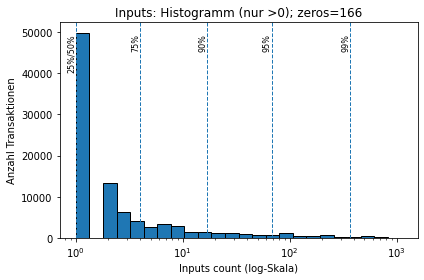


=== Outputs ===
n=94976, zero_count=0, min=1, max=7217, mean=91.338
Quantile:
  25% : 2.000
  50% : 2.000
  75% : 4.000
  90% : 69.000
  95% : 249.000
  99% : 2557.000


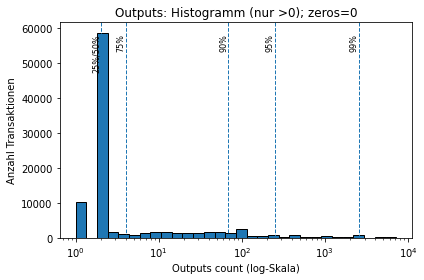

In [294]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_and_plot(name, data, quantile_levels=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99)):
    arr = np.asarray(data, dtype=float)
    arr = arr[~np.isnan(arr)]

    if arr.size == 0:
        print(f"[{name}] Keine Daten.")
        return

    # Kennzahlen
    q_vals = np.quantile(arr, quantile_levels)
    mean_val = float(np.mean(arr))
    zeros = int(np.sum(arr == 0))
    positives = arr[arr > 0]

    print(f"\n=== {name} ===")
    print(f"n={arr.size}, zero_count={zeros}, min={arr.min():.0f}, max={arr.max():.0f}, mean={mean_val:.3f}")
    print("Quantile:")
    for p, v in zip(quantile_levels, q_vals):
        print(f"  {int(p*100):>2d}% : {v:.3f}")

    # ---------- Histogramm (log-X) ----------
    if positives.size > 0:
        min_pos = positives.min()
        max_pos = positives.max()

        # Log-spaced Bins über positiven Bereich
        # 1) Start bei min_pos (oder 1, falls min_pos < 1)
        start = max(1.0, min_pos)
        stop = max_pos
        if start == stop:
            stop = start + 1  # degenerierten Fall vermeiden

        # Anzahl Bins je Dekade (fühl dich frei das zu ändern)
        bins_per_decade = 8
        decades = np.log10(stop) - np.log10(start)
        n_bins = max(10, int(np.ceil(decades * bins_per_decade)))
        bins = np.unique(np.logspace(np.log10(start), np.log10(stop), n_bins))

        fig, ax = plt.subplots()
        ax.hist(positives, bins=bins, edgecolor='black')
        ax.set_xscale('log')
        ax.set_xlabel(f'{name} count (log-Skala)')
        ax.set_ylabel('Anzahl Transaktionen')
        title = f'{name}: Histogramm (nur >0); zeros={zeros}'
        ax.set_title(title)

        # -> gleiche x-Werte zusammenfassen und als "25/50%" beschriften
        groups = []  # Liste von (x, [p1,p2,...])

        for p, v in zip(quantile_levels, q_vals):
            if v <= 0:
                continue
            for g in groups:
                if np.isclose(g[0], v, rtol=1e-8, atol=1e-12):
                    g[1].append(int(p*100))
                    break
            else:
                groups.append((float(v), [int(p*100)]))

        y_top = ax.get_ylim()[1]
        for x, ps in groups:
            ax.axvline(x, linestyle='--', linewidth=1)
            label = "/".join(f"{p}%" for p in sorted(ps))
            ax.text(x, y_top * 0.95, label, rotation=90,
                    va='top', ha='right', fontsize=8)


        plt.tight_layout()
        plt.savefig(f"{name}_count_histogram.png")
        plt.show()
    else:
        print(f"[{name}] Alle Werte sind 0 — Histogramm (log-x) nicht sinnvoll.")


summarize_and_plot("Inputs", inputs)
summarize_and_plot("Outputs", outputs)

#### Check labeling of graphs

In [121]:
for graph in graphs:
    for node in graphs[graph]['nodes']:
        if node['metadata']['type'] == 'classifiable_address':
            print(node['label'])

1
0
0
1
1
0
0
1
1
0
1
0
1
0
0
1
1
0
1
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
1
0
1
0
0
1
1
0
1
0
0
1
1
0
1
0
0
1
0
1


In [93]:
for node in graphs["Graph_3"]['nodes']:
    print(node['metadata']['type'])
    print(node['features'])

tx
[0.6931471805599453, 0.6931471805599453, 0, 175.0, 4500000.0]
address
[0.0, 1, 0.0, 0.7792882500649407, 4500000.0]
classifiable_address
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.5567928730512249, 0.0, 5.0238805208462765, 1, 2500000.0]
classifiable_address
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.4432071269487751, 0.6931471805599453, 1.3862943611198906, 1, 1990000.0]
tx
[0.6931471805599453, 0.6931471805599453, 0, 175.0, 5784500.0]
address
[0.0, 1, 0.0, 0.0019476735685698193, 5784500.0]
address
[1.0986122886681098, 1, 0.6931471805599453, 0.22071174993505932, 1274500.0]
tx
[5.926926025970411, 5.926926025970411, 0, 201.0, 1003800009.0]
address
[0.0, 1, 0.6931471805599453, 0.6578947368421053, 2500000.0]
address
[0.6931471805599453, 1, 0.0, 0.1258997685077269, 2390000.0]
address
[1.0986122886681098, 1, 0.6931471805599453, 0.1745819397993311, 2610000.0]
address
[1.3862943611198906, 1, 0.6931471805599453, 0.03300636857881728, 2400000.0]
address
[1.6094379124341003, 1, 0.0, 0.6

In [94]:
for node in graphs["Graph_3"]['nodes']:
    i = 0
    if node['metadata']['type'] == 'tx':
        print(f"\n{node['metadata']['tx_hash']} {node['metadata']['raw_input_count']} inputs and {node['metadata']['output_count']} outputs")
    if 'address' in node['metadata']['type']:
        print(f"{node['metadata']['type']} with input_index {node['metadata']['input_index']} and output_index {node['metadata']['output_index']}")
#     print(f"{sum([1 for i in node['features'] if i == 0])} out of {len(node['features'])} features are 0")
#     print(node['features'])
#     print()
    print(len(node['features']))


a2770d407defb1bd79103d10b6a3dce5a2204125a8be5d060e868eaba8a7ff70 1 inputs and 2 outputs
5
address with input_index 0 and output_index 0
5
classifiable_address with input_index 151 and output_index 0
14
classifiable_address with input_index 3 and output_index 1
14

84996402dfdb823cc44794f35da982fb2c217af8c3a0b69fb1de6cf2a87ae84e 1 inputs and 2 outputs
5
address with input_index 0 and output_index 0.0
5
address with input_index 2 and output_index 1
5

cfc5719a7120bb9718e175f1ee825ea8856d60a7573ddff56e80658ff5da8feb 374 inputs and 2 outputs
5
address with input_index 0 and output_index 0.6931471805599453
5
address with input_index 1 and output_index 0.0
5
address with input_index 2 and output_index 0.6931471805599453
5
address with input_index 3 and output_index 0.6931471805599453
5
address with input_index 4 and output_index 0.0
5
address with input_index 5 and output_index 0.6931471805599453
5
address with input_index 6 and output_index 0.0
5
address with input_index 7 and output_index

### Checking correct edge correlations

In [ ]:

for edge in graphs["Graph_3"]['edges']:
    src_node = [node['metadata'] for node in graphs['Graph_3']['nodes'] if edge['source'] in node['id']]
    tgt_node = [node['metadata'] for node in graphs['Graph_3']['nodes'] if edge['target'] in node['id']]
    
    source = edge['source'].split('|')[0] if '|' in edge['source'] else edge['source']
    target = edge['target'].split('|')[0] if '|' in edge['target'] else edge['target']
    
    print(edge['type'])
    if 'output_value' in src_node[0]:
        print(src_node[0]['output_value'])
    else:
        print(tgt_node[0]['output_value'])
    print(f"{source} -> {target}\n")

### Expansion for n_hop_neighbourhoods

In [ ]:
from collections import deque

def expand_tx_neighborhood(
    root_tx,
    max_hops: int,
    node_features, node_labels, node_metadata,
    edge_sources, edge_targets, edge_metadata,
    verbose=False,
):
    """
    Explore preceding (inputs->spent_tx) and succeeding (outputs->spending_tx) transactions
    up to `max_hops` layers away from `root_tx`. Uses BFS and avoids revisiting txs.
    """
    if max_hops <= 0:
        return

    visited_tx = set()
    root_hash = str(root_tx.hash).lower()
    visited_tx.add(root_hash)  # root already processed elsewhere

    q = deque()

    # Seed queue with root's neighbors at depth 1
    for inp in root_tx.inputs:
        prev = inp.spent_tx
        if prev:
            q.append((prev, 1))
    for out in root_tx.outputs:
        nxt = out.spending_tx
        if nxt:
            q.append((nxt, 1))

    while q:
        tx, depth = q.popleft()
        tx_hash = str(tx.hash).lower()
        if tx_hash in visited_tx:
            continue
        visited_tx.add(tx_hash)

        # Create nodes/edges for this tx context
        process_tx_context(
            tx,
            node_features, node_labels, node_metadata,
            edge_sources, edge_targets, edge_metadata,
            verbose=verbose
        )

        if depth >= max_hops:
            continue

        # Enqueue neighbors for next layer
        for inp in tx.inputs:
            prev = inp.spent_tx
            if prev:
                prev_hash = str(prev.hash).lower()
                if prev_hash not in visited_tx:
                    q.append((prev, depth + 1))

        for out in tx.outputs:
            nxt = out.spending_tx
            if nxt:
                nxt_hash = str(nxt.hash).lower()
                if nxt_hash not in visited_tx:
                    q.append((nxt, depth + 1))


#### Call this instead of "if include_one_hop"

In [ ]:
# Neighborhood expansion
if neighborhood_hops > 0:
    expand_tx_neighborhood(
        tx,
        max_hops=neighborhood_hops,
        node_features=node_features,
        node_labels=node_labels,
        node_metadata=node_metadata,
        edge_sources=edge_sources,
        edge_targets=edge_targets,
        edge_metadata=edge_metadata,
        verbose=verbose
    )

#### Replace process_one_hop with this

In [ ]:
def process_tx_context(
    tx,
    node_features, node_labels, node_metadata,
    edge_sources, edge_targets, edge_metadata,
    verbose=False,
):
    tx_hash = str(tx.hash).lower()
    if verbose:
        print("\nProcess tx context:", tx_hash)

    is_coinbase_tx = bool(tx.is_coinbase)
    raw_input_count  = len(tx.inputs)
    utxo_input_count = sum(1 for i in tx.inputs if i.spent_tx is not None)
    fee_per_byte     = float(tx.fee_per_byte())
    tx_value         = float(tx.output_value)  # keep consistent with ratios

    tx_features = [
        math.log1p(raw_input_count),
        math.log1p(utxo_input_count),
        fee_per_byte,
        tx_value,
        int(is_coinbase_tx),
    ]

    tx_node_id = create_node_id(tx_hash=tx_hash)

    # if already populated, don't overwrite
    if not node_features.get(tx_node_id):
        node_features[tx_node_id] = tx_features
        node_metadata[tx_node_id] = {
            "type": 'tx',
            "tx_hash": tx_hash,
            "is_coinbase": int(is_coinbase_tx),
            "raw_input_count": raw_input_count,
            "utxo_input_count": utxo_input_count,
            "output_count": len(tx.outputs),
        }
        node_labels[tx_node_id] = -1

    # inputs
    for next_inp_idx, next_inp in enumerate(tx.inputs):
        prev = next_inp.spent_tx if next_inp.spent_tx else None
        prev_hash = str(prev.hash) if prev else None
        prev_idx = next_inp.spent_output.index if prev else None

        process_input(
            next_inp, next_inp_idx, tx, tx_hash,
            node_features, node_labels, node_metadata,
            edge_sources, edge_targets, edge_metadata,
            spent_tx=prev,
            spent_tx_hash=prev_hash,
            spent_idx=prev_idx,
            verbose=verbose,
        )

    # outputs
    for next_out_idx, next_out in enumerate(tx.outputs):
        process_output(
            next_out, next_out_idx, tx, tx_hash,
            node_features, node_labels, node_metadata,
            edge_sources, edge_targets, edge_metadata,
            verbose=verbose
        )
